## Dimensionality Reduction of PubMed and SBIR Embeddings

**Related to Paper Section: “Methods for Research Question 2” (Dimensionality Reduction)**

In this notebook (`PCA.ipynb`), we apply various **dimensionality reduction** techniques (PCA, Kernel PCA, UMAP) to high-dimensional embeddings of PubMed papers and SBIR projects:

1. **Loading Embeddings**  
   - **PubMed**: A dictionary (`pubmed_embeddings_dict`) mapping PMIDs to embedding vectors.  
   - **SBIR**: A dictionary (`sbir_embeddings_dict`) mapping SBIR IDs to embedding vectors.  
   - Concatenate these vectors into one large NumPy array (`embedding_vectors`).

2. **Principal Component Analysis (PCA)**  
   - We perform **2D PCA**:  
     - Fit a `PCA(n_components=2)` to all combined embeddings.  
     - Save the model (`pca2d.pkl`) and transform embeddings to 2D (`pmid2emb2d` / `sbir2emb2d`).  
     - Visualize a random subset of 2D points for PubMed (blue) and SBIR (red).  
     - Print the explained variance for the first two principal components.  
   - We also do **3D PCA**:  
     - Fit a separate `PCA(n_components=3)` on the entire embedding set.  
     - Transform embeddings into 3D (`pmid2emb3d` / `sbir2emb3d`) and visualize them in a 3D scatter plot.  
     - Record the explained variance of each principal component.

3. **Kernel PCA**  
   - As an experimental approach, we illustrate a `KernelPCA(n_components=2, kernel='rbf')` on the embedding set.  
   - (Optional) This can capture non-linear relationships but may be more computationally expensive.

4. **UMAP**  
   - We install and import `umap-learn`.  
   - Fit a UMAP model (`UMAP(n_components=2, metric='cosine', ... )`) to embed the entire embedding set into 2D.  
   - Save the trained UMAP model (`umap2d.pkl`) and the 2D coordinates.  
   - Assign each PubMed and SBIR ID to its 2D embedding (`pmid2emb2d_umap` / `sbir2emb2d_umap`) for subsequent analysis.  
   - Visualize a small random subset of these 2D points in a scatter plot.

5. **Outputs**  
   - This notebook saves:  
     - **PCA models** (`pca2d.pkl`, `pca3d.pkl`),  
     - **UMAP model** (`umap2d.pkl`),  
     - **Transformed embeddings** (2D/3D for both PCA and UMAP).  

These reduced-dimensional embeddings are crucial for **semantic** analyses, such as measuring distance-based similarities (e.g., TVD/JSD/Hellinger) or Triangular Ratios in follow-up notebooks. They help reveal how **PubMed** (academic) and **SBIR** (industrial) distributions align or differ in a low-dimensional space.

In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import torch
import requests
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import random

In [2]:
PICKLES_ADDRESS = '../../data/pickles/'
LAG_DATA_ADDRESS = '../lag_data/'
PUBMED_ADDRESS = '../../data/pubmed_dataset/'
SBIR_ADDRESS = '../../data/sbir_dataset/'

In [3]:
import psutil

def available_memory():
    available_ram = psutil.virtual_memory().available
    print(f"Available RAM: {available_ram / 1024 ** 3:.2f} GB")

def gpu_info():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
    print('GPUs available:', torch.cuda.device_count())
    print('current GPU number: ', torch.cuda.current_device())
    print('GPU name: ', torch.cuda.get_device_name(device))
    print('GPU capability: ', torch.cuda.get_device_capability(device))
    print('GPU memory: ', torch.cuda.get_device_properties(device).total_memory)
    print('GPU memory allocated: ', torch.cuda.memory_allocated(device))
    print('GPU memory cached: ', torch.cuda.memory_reserved(device))
    print('GPU memory reserved: ', torch.cuda.memory_reserved(device))
    print('GPU memory free: ', torch.cuda.memory_reserved(device) - torch.cuda.memory_allocated(device))


def ram_info():
    !free -h


available_memory()
gpu_info()  
ram_info()

Available RAM: 490.62 GB
GPUs available: 3
current GPU number:  0
GPU name:  NVIDIA RTX 6000 Ada Generation
GPU capability:  (8, 9)
GPU memory:  51010207744
GPU memory allocated:  0
GPU memory cached:  0
GPU memory reserved:  0
GPU memory free:  0
               total        used        free      shared  buff/cache   available
Mem:           503Gi       8.6Gi       466Gi       167Mi        27Gi       490Gi
Swap:          1.0Ti          0B       1.0Ti


In [4]:
# read data/pubmed_dataset/pubmed_embeddings_dict.pkl
with open(PUBMED_ADDRESS + 'pubmed_embeddings_dict.pkl', 'rb') as f:
    pubmed_embeddings_dict = pickle.load(f)
print('pubmed_embeddings_dict', len(pubmed_embeddings_dict))

pubmed_embeddings_dict 10928078


In [5]:
available_memory()

Available RAM: 443.54 GB


In [6]:
#read data/sbir_dataset/sbir_embeddings_dict.pkl
with open(SBIR_ADDRESS + 'sbir_embeddings_dict.pkl', 'rb') as f:
    sbir_embeddings_dict = pickle.load(f)
print('sbir_embeddings_dict', len(sbir_embeddings_dict))

sbir_embeddings_dict 63488


In [7]:
available_memory()

Available RAM: 443.28 GB


In [8]:
embedding_vectors = list(pubmed_embeddings_dict.values()) + list(sbir_embeddings_dict.values())
# embedding_vectors = random.sample(list(pubmed_embeddings_dict.values()), 1000000) + list(sbir_embeddings_dict.values())
# embedding_vectors = list(pubmed_embeddings_dict.values())[:5000000] + list(sbir_embeddings_dict.values())
len(embedding_vectors)

10991566

In [9]:
#set the seed for numpy
np.random.seed(0)
embedding_vectors = np.array(embedding_vectors)
np.random.shuffle(embedding_vectors)
embedding_vectors.shape

(10991566, 1024)

### PCA 2D

In [ ]:
#import pca and train it on embedding_vectors
pca = PCA(n_components=2)
pca.fit(embedding_vectors)
pca

In [ ]:
#save pca
with open(PICKLES_ADDRESS + 'pca2d.pkl', 'wb') as f:
    pickle.dump(pca, f)

print('pca', pca)

In [ ]:
#transform pubmed embeddings and sbir embeddings with UMAP. make dictionaries named pmid2emb2d and sbir2emb2d
pmid2emb2d = {}
for pmid, emb in tqdm(pubmed_embeddings_dict.items()):
    pmid2emb2d[pmid] = pca.transform([emb])[0]

sbir2emb2d = {}
for sbir, emb in tqdm(sbir_embeddings_dict.items()):
    sbir2emb2d[sbir] = pca.transform([emb])[0]

#save pmid2emb2d and sbir2emb2d
with open(PICKLES_ADDRESS + 'pmid2emb2d.pkl', 'wb') as f:
    pickle.dump(pmid2emb2d, f)

with open(PICKLES_ADDRESS + 'sbid2emb2d.pkl', 'wb') as f:
    pickle.dump(sbir2emb2d, f)

print('pmid2emb3d', len(pmid2emb2d))
print('sbir2emb3d', len(sbir2emb2d))
print('done')

In [ ]:
#load pmid2emb2d and sbir2emb2d and pca
with open(PICKLES_ADDRESS + 'pmid2emb2d.pkl', 'rb') as f:
    pmid2emb2d = pickle.load(f)

with open(PICKLES_ADDRESS + 'sbid2emb2d.pkl', 'rb') as f:
    sbir2emb2d = pickle.load(f)

with open(PICKLES_ADDRESS + 'pca.pkl', 'rb') as f:
    pca = pickle.load(f)

print('pmid2emb3d', len(pmid2emb2d))
print('sbir2emb3d', len(sbir2emb2d))
print('pca', pca)

In [ ]:
#show 10000 random pubmed embeddings and sbir embeddings. distinguish them with color
pmid2emb2d_sample = random.sample(list(pmid2emb2d.values()), 10000)
sbir2emb2d_sample = random.sample(list(sbir2emb2d.values()), 10000)

plt.figure(figsize=(10, 10))
plt.scatter([x[0] for x in pmid2emb2d_sample], [x[1] for x in pmid2emb2d_sample], s=1, c='b')
plt.scatter([x[0] for x in sbir2emb2d_sample], [x[1] for x in sbir2emb2d_sample], s=1, c='r')
plt.show()

In [ ]:
# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first component: {explained_variance[0]:.4f}")
print(f"Explained variance by the second component: {explained_variance[1]:.4f}")
print(f"Total explained variance by the first two components: {sum(explained_variance):.4f}")

# Optionally, you can visualize the explained variance
plt.bar(['PC1', 'PC2'], explained_variance)
plt.ylabel('Explained Variance')
plt.show()

### PCA 3D

In [ ]:
#import pca and train it on embedding_vectors
pca = PCA(n_components=3)
pca.fit(embedding_vectors)
pca

In [ ]:
#save pca
with open(PICKLES_ADDRESS + 'pca3d.pkl', 'wb') as f:
    pickle.dump(pca, f)

print('pca', pca)

In [ ]:
#transform pubmed embeddings and sbir embeddings with pca. make dictionaries named pmid2emb3d and sbir2emb3d
pmid2emb3d = {}
for pmid, emb in tqdm(pubmed_embeddings_dict.items()):
    pmid2emb3d[pmid] = pca.transform([emb])[0]

sbir2emb3d = {}
for sbir, emb in tqdm(sbir_embeddings_dict.items()):
    sbir2emb3d[sbir] = pca.transform([emb])[0]

#save pmid2emb3d and sbir2emb3d
with open(PICKLES_ADDRESS + 'pmid2emb3d.pkl', 'wb') as f:
    pickle.dump(pmid2emb3d, f)

with open(PICKLES_ADDRESS + 'sbid2emb3d.pkl', 'wb') as f:
    pickle.dump(sbir2emb3d, f)

print('pmid2emb3d', len(pmid2emb3d))
print('sbir2emb3d', len(sbir2emb3d))
print('done')

In [ ]:
#show 10000 random pubmed embeddings and sbir embeddings. distinguish them with color. use plotly 3d
pmid2emb3d_sample = random.sample(list(pmid2emb3d.values()), 10000)
sbir2emb3d_sample = random.sample(list(sbir2emb3d.values()), 10000)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pmid2emb3d_sample],
    y=[point[1] for point in pmid2emb3d_sample],
    z=[point[2] for point in pmid2emb3d_sample],
    mode='markers',
    marker=dict(color='blue')
))

fig.add_trace(go.Scatter3d(
    x=[point[0] for point in sbir2emb3d_sample],
    y=[point[1] for point in sbir2emb3d_sample],
    z=[point[2] for point in sbir2emb3d_sample],
    mode='markers',
    marker=dict(color='red')
))

fig.update_layout(scene=dict(
    xaxis=dict(title='X'),
    yaxis=dict(title='Y'),
    zaxis=dict(title='Z')
))

fig.show()

In [ ]:
# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first component: {explained_variance[0]:.4f}")
print(f"Explained variance by the second component: {explained_variance[1]:.4f}")
print(f"Explained variance by the third component: {explained_variance[2]:.4f}")
print(f"Total explained variance by the first two components: {sum(explained_variance):.4f}")

# Optionally, you can visualize the explained variance
plt.bar(['PC1', 'PC2', 'PC3'], explained_variance)
plt.ylabel('Explained Variance')
plt.show()

### Kernel PCA 2D

In [ ]:
embedding_vectors_float8 = embedding_vectors.astype(np.float64)
embedding_vectors_float8.shape

In [ ]:
# reduce the dimension of embedding_vectors to 2d with kernel pca
kpca = KernelPCA(n_components=2, kernel='rbf')
kpca.fit(embedding_vectors_float8)
kpca

### UMAP 2D

In [10]:
!pip install umap-learn
# !pip install numba==0.55.1
# !pip install numpy==1.21.0

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import umap

In [ ]:
#use UMAP to fit embedding_vectors to 2d
umap2d = umap.UMAP(n_components=2, random_state=0, n_neighbors=3, min_dist=0.99, metric='cosine', verbose=True)
# embedding_vectors_stratified_sample = random.sample(list(embedding_vectors), 1000000)
umap2d.fit(embedding_vectors)
umap2d

In [ ]:
#save ump
with open(PICKLES_ADDRESS + 'umap2d.pkl', 'wb') as f:
    pickle.dump(umap2d, f)

print('UMAP', umap2d)

In [ ]:
import joblib
# Save the UMAP model to a file
model_filename = "umap_model.pkl"
joblib.dump(umap2d, PICKLES_ADDRESS + model_filename)

In [12]:
with open(PICKLES_ADDRESS + 'umap2d.pkl', 'rb') as f:
    umap2d = pickle.load(f)
print('umap2d', umap2d)

Mon Jul 24 06:04:28 2023 Building and compiling search function
umap2d UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.99, n_neighbors=3, random_state=0, verbose=True)


In [16]:
embedding_vectors_2d_umap = umap2d.transform(embedding_vectors)
#save embedding_vectors_2d_umap
with open(PICKLES_ADDRESS + 'embedding_vectors_2d_umap.pkl', 'wb') as f:
    pickle.dump(embedding_vectors_2d_umap, f)
print('embedding_vectors_2d_umap', embedding_vectors_2d_umap.shape)

Epochs completed:   0%|            0/30 [00:00]

embedding_vectors_2d_umap (10991566, 2)


In [17]:
pmid2emb2d = {}
for i, pmid in tqdm(enumerate(pubmed_embeddings_dict.keys())):
    pmid2emb2d[pmid] = embedding_vectors_2d_umap[i]

sbir2emb2d = {}
c = len(list(pubmed_embeddings_dict.keys()))
for i, sbir in tqdm(enumerate(sbir_embeddings_dict.keys())): 
    sbir2emb2d[sbir] = embedding_vectors_2d_umap[c + i]

#save pmid2emb2d and sbir2emb2d
with open(PICKLES_ADDRESS + 'pmid2emb2d_umap.pkl', 'wb') as f:
    pickle.dump(pmid2emb2d, f)

with open(PICKLES_ADDRESS + 'sbid2emb2d_umap.pkl', 'wb') as f:
    pickle.dump(sbir2emb2d, f)

print('pmid2emb2d', len(pmid2emb2d))    
print('sbir2emb2d', len(sbir2emb2d))
print('done')

10928078it [00:04, 2328645.59it/s]
63488it [00:00, 2427597.02it/s]


pmid2emb2d 10928078
sbir2emb2d 63488
done


In [12]:
#load pmid2emb2d_umap and sbir2emb2d_umap and umap2d
with open(PICKLES_ADDRESS + 'pmid2emb2d_umap.pkl', 'rb') as f:
    pmid2emb2d_umap = pickle.load(f)

with open(PICKLES_ADDRESS + 'sbid2emb2d_umap.pkl', 'rb') as f:
    sbir2emb2d_umap = pickle.load(f)

with open(PICKLES_ADDRESS + 'umap2d.pkl', 'rb') as f:
    umap2d = pickle.load(f)

print('pmid2emb2d_umap', len(pmid2emb2d_umap))
print('sbir2emb2d_umap', len(sbir2emb2d_umap))
print('umap2d', umap2d)

Mon Jul 24 10:31:49 2023 Building and compiling search function
pmid2emb2d_umap 10928078
sbir2emb2d_umap 63488
umap2d UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.99, n_neighbors=3, random_state=0, verbose=True)


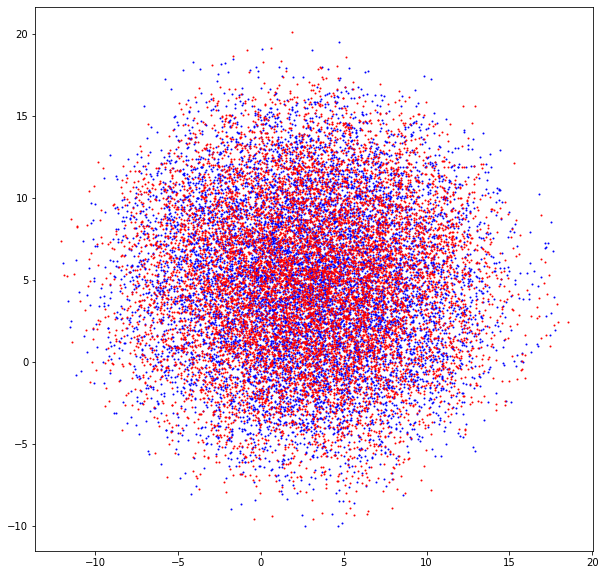

In [14]:
#show 10000 random pubmed embeddings and sbir embeddings. distinguish them with color
pmid2emb2d_umap_sample = random.sample(list(pmid2emb2d_umap.values()), 10000)
sbir2emb2d_umap_sample = random.sample(list(sbir2emb2d_umap.values()), 10000)

plt.figure(figsize=(10, 10))
plt.scatter([x[0] for x in pmid2emb2d_umap_sample], [x[1] for x in pmid2emb2d_umap_sample], s=1, c='b')
plt.scatter([x[0] for x in sbir2emb2d_umap_sample], [x[1] for x in sbir2emb2d_umap_sample], s=1, c='r')
plt.show()